In [60]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']= 16,5
from __future__ import division

In [61]:
import pandas as pd
import csv
import os
import time
import gc

In [4]:
def load_data():
    """
Function to load data
    :return: data vector, data target, data mean, data standar deviation 
    """
    data = np.genfromtxt('Resources/data.csv', delimiter=',')
    d_mean = np.mean(data)
    d_std = np.std(data)
    target = data[-12:-6]
    data = (data - d_mean) / d_std    
    return data, target, d_mean, d_std

In [5]:
def get_TS():
    rawData = pd.read_csv('Resources/Consulta_Banxico.csv', sep=',', encoding='latin1', skiprows=15, skip_blank_lines=True)
    Data = rawData.drop(rawData.index[:2])
    Data = Data.reset_index(drop = True)
    Data.columns = ['Fecha' , 'Tasa de crecimiento Mensual']
    TS = pd.Series(Data['Tasa de crecimiento Mensual'].astype(float))
    TS.index= Data['Fecha']
    del Data
    return TS

In [6]:
def generate_win_matrix(inSize, resSize, scaleFactor=1):
    """
Function to generate W in matrix with a uniform distribution between [-1,1]
in other Function the uniform distribution can be moved to any range
    :param inSize: number of inputs without interceptor
    :param resSize: size of reservoir
    :param scaleFactor: Scale Factor for the matrix by default 1
    :return: W in Matrix
    """
    Win = (random.uniform(low=-1, high=1, size=(resSize, 1 + inSize))) * scaleFactor
    return Win

In [7]:
def generate_w_matrix(resSize):
    """
Function to generate W matrix with a uniform distribution between [-1,1]
 In other function the uniform distribution can be moved to any range
    :param resSize: size of reservoir
    :return: W matrix
    """
    W = random.uniform(low=-1, high= 1, size = (resSize,resSize))
    return  W

In [8]:
def get_spectral_radius(W):
    """
Function to get the spectral radius of W matrix
    :param W: W matrix
    :return: spectral radius
    """
    rhoW = max(abs(linalg.eig(W)[0]))
    return  rhoW

In [9]:
def scale_w(W,rhoW, SRS = 2):
    """
Function to apply spectral radius scale factor
    :param W: W matrix
    :param rhoW: spectral radius
    :param SRS: spectral radius scale factor by default 1
    :return: W
    """
    W*= (SRS/ rhoW)
    return W

In [10]:
def get_x_yt_matrix(data,inSize, resSize,trainLen,initLen):
    """
Function to get X and Yt Matrix to save activation states and prediction targets
    :type data: normalized data
    :param inSize: size of the input 
    :param resSize: size of reservoir
    :param trainLen: length of train data
    :param initLen:  length of initial data
    :return: X, Yt
    """
    X = zeros((1+inSize+resSize,trainLen-initLen))
    Yt = data[None,initLen+1:trainLen+1]
    return X,Yt

In [11]:
def get_activation_states(data,resSize,trainLen,initLen,Win,W,a,X):
    """
Function to get the activations states from the reservoir
    :param data: train data
    :param resSize: reservoir size
    :param trainLen: length of train data
    :param initLen: inital data to be ignored
    :param Win: W in Matrix
    :param W: W matrix
    :param a: leaking rate
    :param X: matrix of Activations per input
    :return: last activation vector, matrix of activations X
    """
    x = zeros((resSize,1))
    for t in range(trainLen):
        u = data[t]
        x_u = tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
        x = (1-a)*x + a*x_u 
        if t >= initLen:
            X[:,t-initLen] = vstack((1,u,x))[:,0]
    return x,X

In [12]:
def train_output_l2(inSize,resSize,X,Yt,reg = 1e-8):
    """
Function to train readout with ridge regression to address overfitting
    :param inSize: size of input
    :param resSize: reservoir size
    :param reg: penalization parameter
    :param X: Matrix of activations
    :param Yt: target values
    :return Wout: weights from reservoir and input to output layer
    """
    X_T = X.T 
    Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + reg*eye(1+inSize+resSize) ) )
    return Wout

In [13]:
def get_predictions(data,outSize,trainLen,testLen,a,Win,W,Wout,x):
    """
Function to get the predictions of the normalized data
    :param data: train data
    :param outSize: output size
    :param trainLen: length of train data
    :param testLen: length of test data
    :param a: leaking rate
    :param Win: W in Matrix
    :param W: W matrix
    :param Wout: W out Matrix
    :param x: last activations states
    :return: vector of predictions
    """
    Y = zeros((outSize,testLen))
    u = data[trainLen]
    for t in range(testLen):
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
        y = dot( Wout, vstack((1,u,x)) )
        Y[:,t] = y
        # generative mode, this take the prediction and use it to make other prediction:
        u = y
        ## this would be a predictive mode, this made a prediccion and save it, then use the true value to make a new prediction:
        #u = data[trainLen+t+1]
    return Y

In [14]:
def denormalize_predictions(d_mean,d_std,Y):
    """
Function to denormalize predictions
    :param d_mean: data mean
    :param d_std: data standard deviation
    :param Y: predictions
    :return: denormalized predictions
    """
    Y1 = (Y * d_std) + d_mean
    return Y1

In [85]:
def get_MSE(predictions, target):
    """
    Function to get MSE from diference between predictions and real value (ouptuts)
    :param predictions: predictions made by ffnn
    :param target: true values from output values
    :return: MSE
    """
    return  (np.sum((target - predictions)**2))/len(predictions)

In [105]:
def SolutionValidation(Predictions,MSE,bestESN,bestMSE,bestPredictions,currentSetup):
    """
Function to validate ESN model
    :param Predictions: Prediction of current ESN
    :param MSE: MSE of current ESN
    :param bestESN: best setup of ESN so far
    :param bestMSE: MSE of best ESN so far
    :param bestPredictions: predictions of best ESN so far
    :param currentSetup: current ESN setup
    :return: bestESN, bestPredictions, bestMSE
    """
    print (str)(MSE) +  '-'
    if(MSE < bestMSE):
        bestESN = currentSetup
        bestMSE = MSE
        bestPredictions = Predictions
    return bestESN,bestPredictions,bestMSE

In [106]:
def init_best():
    best_setup = (0,0,0,0,0)
    best_mse = 1000000000000
    best_pred = (0,0,0,0,0,0)
    return best_setup,best_mse,best_pred

In [107]:
def toCSV(folder,name,esn,mse,pred,TS):
    if not os.path.isdir(folder):
        os.makedirs(folder)
    with open(folder + name + '.csv','w+') as csvfile:
        spamwriter= csv.writer(csvfile,delimiter=',')
        spamwriter.writerow(['ESN configuration: ',esn])
        spamwriter.writerow(['predictions'])
        spamwriter.writerow(pred)
        spamwriter.writerow(['MSE:' , mse])
        csvfile.close()        
    plot_Solutions(folder,name,pred,TS)

In [108]:
def plot_Solutions(folder,name,Pred,TS):
    """
    Function to Plot List of predictions, mean predictions and Original Time Serie
    :param folder: path of file
    :param name: name of file
    :param Pred: predictions
    :param TS: Original Time Serie
    :return: matplotlib fig
    """
    fig = figure()
    TSValOutputs = TS[len(TS)-13:len(TS)-6].copy()
    TSValOutputs.plot(style= 'ko-')
    
    TSPred = pd.Series(Pred.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
    TSPrediction = TS[len(TS)-13:len(TS)-6].copy()
    TSPrediction[1:] = TSPred
    TSPrediction.plot(style= 'bo-')
    lineMean = mlines.Line2D([],[],color='blue', marker='o',label = 'Prediction')
    lineVal = mlines.Line2D([],[],color='black', marker='o',label = 'True Values')
    legend(handles = [lineMean,lineVal],loc= 1)
    fig.savefig(folder + name + ".png")
    del fig
    gc.collect()

In [109]:
def get_best_setup(ParameterList):
    """
Function to test several ESN model for the best setup
    :param ParameterList: List of vectors for different values of the parameters in this order:
    resSize, inputScale, SpectralRadiusScale, leakingRate, l2penalty
    """    
    random.seed(42)
    data,target,d_mean,d_std = load_data()
    trainLen =len(data) - 13
    testLen = 6
    initLen = 12
    inSize = outSize = 1
    TS = get_TS()
    folder = "Results/" + time.strftime("%d-%m") + "_" + time.strftime("%H-%M") +"/" 
    best_setup,best_MSE,best_predictions = init_best()
    param1 = 0   
    for resSize in ParameterList[0]:
        name1 = ((str)(param1) + '-')
        param1 += 1
        param2 = 0
        for WinScale in ParameterList[1]:
            name2 = name1 + (str)(param2) + '-'
            param2 += 1
            param3 = 0
            Win = generate_win_matrix(inSize,resSize,WinScale)
            for SRS in ParameterList[2]:
                name3 = name2 + (str)(param3) + '-'
                param3 += 1
                param4 = 0
                W = generate_w_matrix(resSize)            
                rhoW = get_spectral_radius(W)
                W = scale_w(W,rhoW,SRS)
                X,Yt = get_x_yt_matrix(data,inSize,resSize,trainLen,initLen)
                for a in ParameterList[3]:
                    name4 = name3 + (str)(param4) + '-'
                    param4 += 1
                    param5 = 0
                    x,X = get_activation_states(data,resSize,trainLen,initLen,Win,W,a,X)
                    for reg in ParameterList[4]:
                        name5 = name4 + (str)(param5)
                        param5 += 1
                        Wout = train_output_l2(inSize,resSize,X,Yt,reg)
                        Y = get_predictions(data,outSize,trainLen,testLen,a,Win,W,Wout,x)
                        print Y
                        Y = denormalize_predictions(d_mean,d_std,Y)
                        MSE = get_MSE(Y[0],target)
                        currentSetup = (resSize,WinScale,SRS,a,reg)
                        toCSV(folder,name5,currentSetup,MSE,Y[0],TS)
                        best_setup,best_MSE,best_predictions = SolutionValidation(Y[0],MSE,best_setup,best_MSE,best_predictions,currentSetup)
    return best_setup,best_MSE,best_predictions

In [102]:
ParameterList = [[100],[1],[2],[0.1],[1e-9,1e-8,1e-5,1e-2,1e-1,1,10]]

[[-0.66643156 -0.14859075  0.32475185 -1.03485726 -0.97563202  0.56732478]]


TypeError: unsupported operand type(s) for +: 'numpy.float64' and 'str'

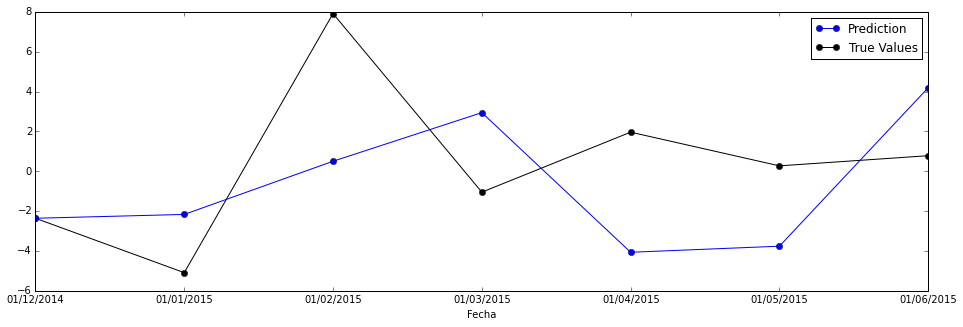

In [103]:
bSet,bPred,bMSE = get_best_setup(ParameterList)